<a href="https://colab.research.google.com/github/uchibe/BIAI/blob/main/notebooks/One_state_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Action selection
## Epsilon-greedy policy

\begin{equation*}
  \pi (a) =
  \begin{cases}
    \epsilon/\lvert A \rvert + 1 - \epsilon & \mathrm{if} \; \;
       a = \mathrm{arg} \max_a Q(a) \\
    \epsilon/\lvert A \rvert & \mathrm{otherwise}
  \end{cases}
\end{equation*}

In [3]:
def epsilon_greedy_policy(Q, epsilon):
    n_actions = Q.shape[0]
    policy = epsilon/n_actions*np.ones(n_actions)
    policy[Q.argmax(0)] += 1 - epsilon

    return policy


def plot_epsilon_greedy_policy(Q, epsilon=0.1):
    policy = epsilon_greedy_policy(Q, epsilon)
    action = np.arange(Q.shape[0])

    fig = plt.figure(figsize=(12,5))
    axarr = fig.subplots(1, 2)
    axarr[0].bar(action, Q)
    axarr[0].set_xlabel('action a')
    axarr[0].set_ylabel('action value Q(a)')

    axarr[1].bar(action, policy, label=r'$\epsilon$ = %3.1f' % epsilon)
    axarr[1].set_xlabel('action a')
    axarr[1].set_ylabel(r'policy $\pi$ (a)')
    plt.legend()
    plt.show()

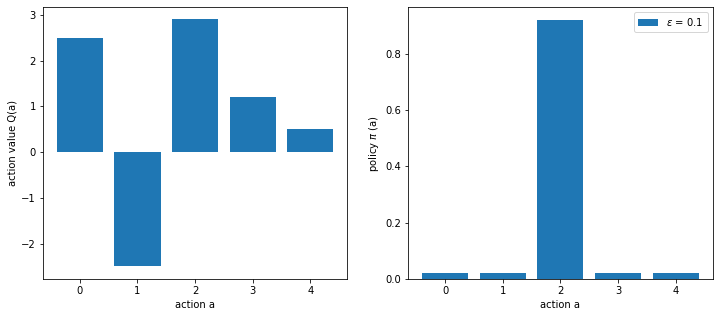

In [4]:
epsilon = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
Q = np.array([2.5, -2.5, 2.9, 1.2, 0.5])
plot_epsilon_greedy_policy(Q, epsilon=epsilon)

## Boltzmann distribution
\begin{equation*}
  \pi (a) = \frac{ \exp (\beta Q(a)) }{\sum_{a'} \exp (\beta Q(a')) }
\end{equation*}

In [5]:
def Boltzmann_policy(Q, beta=1.0):
    Qmax = np.max(Q)
    expQ = np.exp(beta * (Q - Qmax))
    policy = expQ / np.sum(expQ)

    return policy


def plot_Boltzmann_policy(Q, beta):
    policy = Boltzmann_policy(Q, beta)
    action = np.arange(Q.shape[0])

    fig = plt.figure(figsize=(12,5))
    axarr = fig.subplots(1, 2)
    axarr[0].bar(action, Q)
    axarr[0].set_xlabel('action a')
    axarr[0].set_ylabel('action value Q(a)')

    axarr[1].bar(action, policy, label=r'$\beta$ = %3.1f' % beta)
    axarr[1].set_xlabel('action a')
    axarr[1].set_ylabel(r'policy $\pi$ (a)')
    plt.legend()
    plt.show()

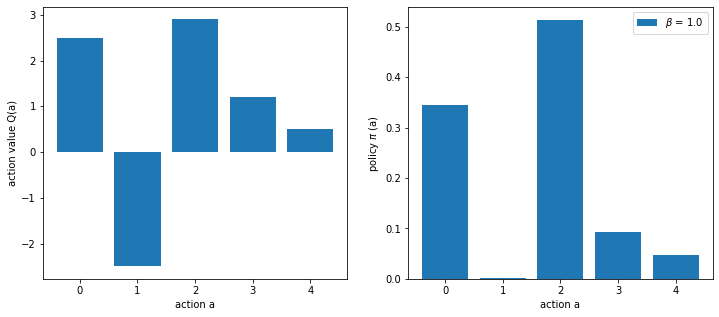

In [6]:
beta = 1 #@param {type:"slider", min:0, max:5, step:0.2}
Q = np.array([2.5, -2.5, 2.9, 1.2, 0.5])
plot_Boltzmann_policy(Q, beta=beta)

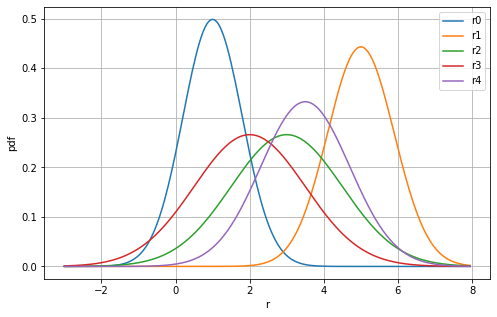

In [7]:
import gym
import gym.spaces
from scipy import stats


class GaussianBandit(gym.core.Env):
    def __init__(self):
        self.n_machines = 5
        self.action_space = gym.spaces.Discrete(self.n_machines)
        self.observation_space = gym.spaces.Discrete(1)

        self.mu = np.array([1.0, 5.0, 3.0, 2.0, 3.5])
        self.sigma = np.array([0.8, 0.9, 1.5, 1.5, 1.2])

    def _step(self, action):
        done = True
        reward = np.random.normal(self.mu[action], self.sigma[action])
        return np.array([0]), reward, done, {}

    def _reset(self):
        return np.array([0])

    def plot(self):
        fig = plt.figure(figsize=(8,5))
        axarr = fig.subplots(1, 1)

        x = np.arange(start=-3.0, stop=8.0, step=0.05)
        for index, mean in enumerate(self.mu):
            std = self.sigma[index]
            norm_pdf = stats.norm.pdf(x=x, loc=mean, scale=std)
            axarr.plot(x, norm_pdf, label='r%1.0f' % index)
        axarr.legend()
        axarr.set_xlabel('r')
        axarr.set_ylabel('pdf')
        axarr.grid()


env = GaussianBandit()
env.plot()

## Value-based method

\begin{equation*}
  Q(a) = Q(a) + \alpha (r - Q(a)),
\end{equation*}
where $\alpha$ is a learning rate. 

In [8]:
import sys
def value_based_method(method, beta=1.0, epsilon=0.1, number_of_steps=1000):
    env = GaussianBandit()

    Q = np.zeros([env.action_space.n, number_of_steps+1])   # initialize an action value function
    N = np.zeros([env.action_space.n, number_of_steps+1])   # number of times "a" taken
    average_reward = 0

    for t in range(number_of_steps):
        if method == 'epsilon':
            policy = epsilon_greedy_policy(Q[:, t], epsilon=epsilon)
            action = np.random.choice(range(env.action_space.n), p=policy)
        elif method == 'Boltzmann': 
            policy = Boltzmann_policy(Q[:, t], beta=beta)
            action = np.random.choice(range(env.action_space.n), p=policy)
        else:
          sys.exit()  
        _, reward, _, _ = env._step(action)
        
        # compute the learning rate
        N[:, t+1] = N[:, t] + np.identity(env.action_space.n)[action]
        Q[:, t+1] = Q[:, t] # unselected actions
        alpha = 1/(N[action, t+1]) # learning rate
        # update the action value function
        Q[action,t+1] = Q[action,t] + alpha*(reward - Q[action,t])
        
        average_reward += reward
    
    # plot the learning curves of the action values
    average_reward /= number_of_steps
    fig = plt.figure(figsize=(12,5))
    axarr = fig.subplots(1, 2)
    for i in range(env.action_space.n):
        axarr[0].plot(Q[i, :], label='$a%i$' % i)
    axarr[0].legend()
    axarr[0].set_xlabel('steps')
    axarr[0].set_ylabel('action value Q(a)')
    axarr[0].grid()
    for i in range(env.action_space.n):
        axarr[1].plot(N[i, :], label='$N%i$' % i)
    axarr[1].legend()
    axarr[1].set_xlabel('steps')
    axarr[1].set_ylabel('N (a)')
    axarr[1].grid
    
    print(Q[:, -1])
    print('average reward: %f' % average_reward)

[1.03546231 4.99520482 3.42996079 1.9874613  3.76298185]
average reward: 4.750286


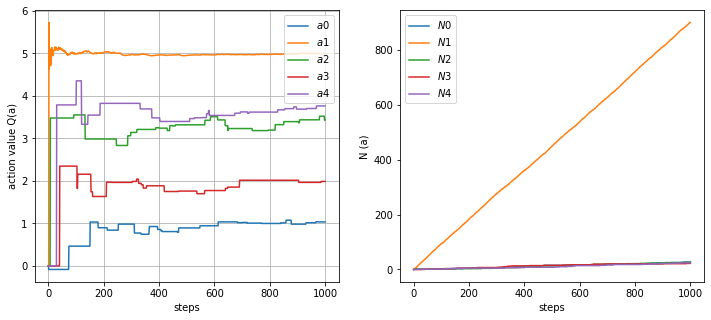

In [9]:
epsilon = 0.1 #@param {type:"slider", min:0, max:1, step:0.05}
value_based_method('epsilon', epsilon=epsilon)

[1.26811854 5.02190086 2.52497342 1.8934063  3.30770179]
average reward: 4.408718


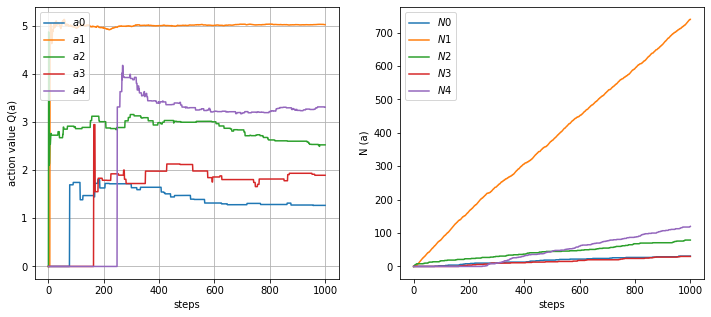

In [10]:
beta = 1 #@param {type:"slider", min:0, max:5, step:0.2}
value_based_method('Boltzmann', beta=beta)

## Gradient descent

Consider the minimization problem: $\min_\theta J(x)$, where $J(x)$ is differentiable. The local optimal solution is obtained by applying gradient descent:
\begin{equation*}
x = x - \alpha \nabla_{x} J(x)
\end{equation*}

In [11]:
def eval_objective(x):
    Jx = 10*np.power(x, 2)
    dJx = 20*x
    return Jx, dJx

def optimize_by_gd(x_init, n_iterations, alpha):
    x = np.zeros(n_iterations+1)
    x[0] = x_init
    y = np.zeros(n_iterations+1)
    dy = np.zeros(n_iterations+1)
    for i in range(n_iterations):
        y[i], dy[i] = eval_objective(x[i])
        x[i+1] = x[i] - alpha*dy[i]
    y[-1], dy[-1] = eval_objective(x[-1])
    return x, y, dy


def plot_result(x, y, dy):
    xx = np.arange(-100, 100)
    Jx, _ = eval_objective(xx)
    
    fig = plt.figure(figsize=(12,5))
    axarr = fig.subplots(1, 2)
    axarr[0].plot(xx, Jx)
    axarr[0].plot(x, y, 'ro-')
    axarr[0].set_xlabel('x')
    axarr[0].set_ylabel('J(x)')
    axarr[1].plot(dy, 'ro-')
    axarr[1].set_xlabel('iteration')
    axarr[1].set_ylabel('dJ(x)/dx')

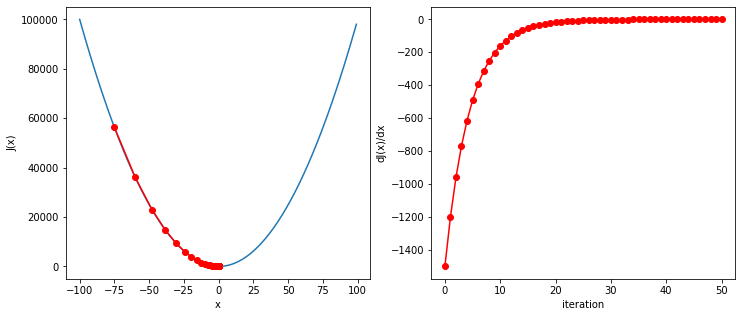

In [12]:
alpha = 0.01 #@param {type:"slider", min:0.01, max:0.1, step:0.005}
x, y, dy = optimize_by_gd(x_init=-75, n_iterations=50, alpha=alpha)
plot_result(x, y, dy)

## Policy-based method

In [13]:
def policy_based_method(method='reduction', alpha=0.05, number_of_steps=1000):
    env = GaussianBandit()

    theta = np.zeros([env.action_space.n, number_of_steps+1])   # initialize a policy parameter
    N = np.zeros([env.action_space.n, number_of_steps+1])   # number of times "a" taken
    average_reward = 0

    for t in range(number_of_steps):
        # compute a policy from the policy parameters
        policy = Boltzmann_policy(theta[:, t], beta=1.0)
        action = np.random.choice(range(env.action_space.n), p=policy)
        _, reward, _, _ = env._step(action)
        
        N[:, t+1] = N[:, t] + np.identity(env.action_space.n)[action]
        gradient = np.identity(env.action_space.n)[action] - policy
        if method == 'reduction':
            theta[:, t+1] = theta[:, t] + alpha*(reward - average_reward/(t+1))*gradient 
        elif method == 'no reduction':
            theta[:, t+1] = theta[:, t] + alpha*reward*gradient
        else:
            sys.exit()
        
        average_reward += reward
    
    # plot the learning curves of the action values
    average_reward /= number_of_steps
    fig = plt.figure(figsize=(12,5))
    axarr = fig.subplots(1, 2)
    for i in range(env.action_space.n):
        axarr[0].plot(theta[i, :], label='$a%i$' % i)
    axarr[0].legend()
    axarr[0].set_xlabel('steps')
    axarr[0].set_ylabel('policy parameter theta')
    axarr[0].grid()
    for i in range(env.action_space.n):
        axarr[1].plot(N[i, :], label='$N%i$' % i)
    axarr[1].legend()
    axarr[1].set_xlabel('steps')
    axarr[1].set_ylabel('N')
    axarr[1].grid

    print('average reward: %f' % average_reward)

average reward: 4.676651


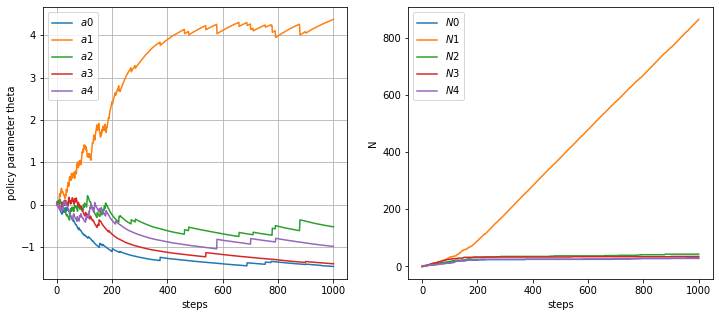

In [14]:
alpha = 0.03 #@param {type:"slider", min:0.01, max:0.1, step:0.005} 
policy_based_method('no reduction', alpha=alpha)

average reward: 4.722558


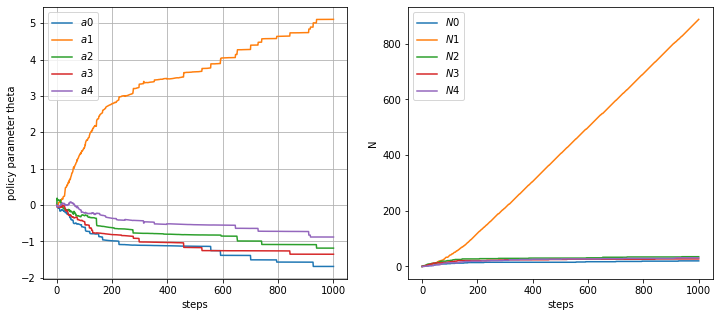

In [15]:
alpha = 0.03 #@param {type:"slider", min:0.01, max:0.1, step:0.005} 
policy_based_method('reduction', alpha=alpha)